In [74]:
import os, shutil
from os import listdir
from os.path import isfile, join
import random

In [ ]:
print(os.getcwd())

#creo lista di nomi 
directories = ['data/train/', 
               'data/val/', 
               'data/test/']

train_file_names = [f for f in listdir(directories[0]) if isfile(join(directories[0], f))]
val_file_names = [f for f in listdir(directories[1]) if isfile(join(directories[1], f))]
test_file_names = [f for f in listdir(directories[2]) if isfile(join(directories[2], f))]

_file_names = [train_file_names, val_file_names, test_file_names] 

In [81]:
#numero immagini per categoria
scans = ['CT','MRI','PET']
numbers=[]
minimi=[]

for directory in directories:    
    for scan in scans:
        a = len([f for f in listdir(directory) if f[:2]==scan[:2]])
        print('Numbero di immagini', scan, 'in', directory,':', a)
        numbers.append(a)
    minimi.append(min(numbers))

#print(minimi)
#=> è sempre la PET che ha il numero minore

Numbero di immagini CT in data/train/ : 443
Numbero di immagini MRI in data/train/ : 489
Numbero di immagini PET in data/train/ : 343
Numbero di immagini CT in data/val/ : 142
Numbero di immagini MRI in data/val/ : 170
Numbero di immagini PET in data/val/ : 114
Numbero di immagini CT in data/test/ : 71
Numbero di immagini MRI in data/test/ : 86
Numbero di immagini PET in data/test/ : 57


In [82]:
#creo la lista di file bilanciata: n.b  la percentuale viene mantenuta
train_final_file_names=[]
val_final_file_names=[]
test_final_file_names=[]
_final_file_names = [train_final_file_names, val_final_file_names, test_final_file_names] 

l=[]
for directory,minimo,name in zip(directories, minimi,_final_file_names):    
    for scan in scans:
        l = [f for f in listdir(directory) if f[:2]==scan[:2]]
        random.shuffle(l)
        l = l[:minimo]
        name.extend(l) #estendo la lista (don't append)
        
# How I cicled ^^^

#    minimo |
#    name   |
#    train  | val | test
# 
# CT    ... | ... | ...
# MRI   ... | ... | ...
# PET   ... | ... | ...

In [83]:
print("DATASET")
print("Training", len(train_final_file_names), ", Validation:", len(val_final_file_names) ,", Test:", len(test_final_file_names))

DATASET
Training 1029 , Validation: 342 , Test: 171


## Converto le immagini in tensori

In [84]:
from skimage import io
import matplotlib.pyplot as plt
import cv2

### X

In [85]:
def WriteAndArrayImages(path):
    x = io.imread(path[random.randint(0,10)])
    x = cv2.resize(x, dsize=(128,128))
    
    for img in path[1:]:
        img = io.imread(img)
        img = cv2.resize(img, dsize=(128,128))
        x = np.dstack((x,img))
    x = np.rollaxis(x,-1)
    return x

(1029, 128, 128)
(342, 128, 128)
(171, 128, 128)


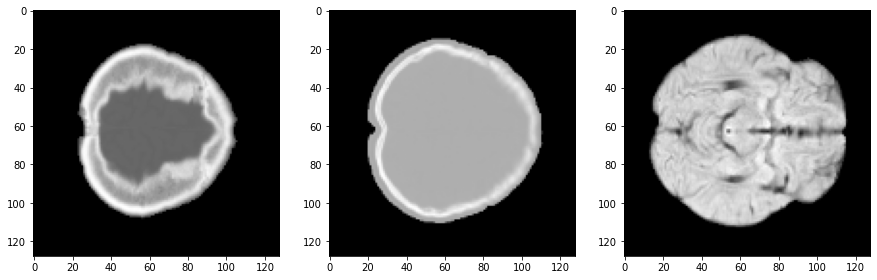

In [295]:
import numpy as np

#paths per leggere le immagini
train_paths=[]
val_paths=[]
test_paths=[]
_paths=[train_paths,val_paths,test_paths]

for path,name,directory in zip(_paths,_final_file_names,directories):
    for f in name:
        path.append(directory+f)

#leggo le immagini e le stacco una sopra l'altra
x_train = WriteAndArrayImages(train_paths)
x_val = WriteAndArrayImages(val_paths)
x_test = WriteAndArrayImages(test_paths)

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

#plot images from each dataset
f, axarr = plt.subplots(1,3,figsize=(15, 15))
axarr[0].imshow(x_train[random.randint(0,100)], cmap=plt.cm.gray)
axarr[1].imshow(x_val[random.randint(0,100)], cmap=plt.cm.gray)
axarr[2].imshow(x_test[random.randint(0,100)], cmap=plt.cm.gray)

### Y

In [87]:
def MakeLabels(_name_files):
    y=[]
    for text in _name_files:
        fileNameOnly = text[:text.find(ext)]
        y.append(''.join([i for i in fileNameOnly if not i.isdigit()]))
    for i, item in enumerate(y):
        if item == 'CT':
            y[i] = 0
        elif item == 'MRI':
            y[i] = 1
        else: y[i] = 2    
    y = np.concatenate((y,))
    return y

In [88]:
#estensione immagini
ext = '.png'

#costruisco le lables
y_train = MakeLabels(_final_file_names[0])
y_val = MakeLabels(_final_file_names[1])
y_test = MakeLabels(_final_file_names[2])

In [89]:
#check
X = [x_train, x_val, x_test]
Y = [y_train, y_val, y_test]

for x,y in zip(X,Y):
    if len(x) != len(y):
        print(len(x))
        print(len(y))
        print('Error! La lunghezza delle liste non combacia!')
    else: 
        print('Ok, le lunghezze combaciano con le X')

#controlla numero di cluster (expected 3)
n_clusters = len(np.unique(y))
print('Clusters:', n_clusters)

Ok, le lunghezze combaciano con le X
Ok, le lunghezze combaciano con le X
Ok, le lunghezze combaciano con le X
Clusters: 3


### Reshape images for autoencoder

In [90]:
#use this function for reshaping arrays for CAE
def ReshapeCAE(array):
    array = array.reshape(array.shape + (1,))
    array = array/255.
    return array

x_train = ReshapeCAE(x_train)
x_val = ReshapeCAE(x_val)
x_test = ReshapeCAE(x_test)

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(1029, 128, 128, 1)
(342, 128, 128, 1)
(171, 128, 128, 1)


# Convolutional Autoencoder

In [298]:
from keras.models import Model
from keras import backend as K
from keras import layers
from keras.layers import Input, Dense, Conv2D , Flatten, Reshape, Conv2DTranspose
from keras.models import Model

## CAE Conv2DTranspose

In [301]:
def CAE_Conv2DTranspose(input_shape=(128, 128, 1), filters=[32, 64, 128, 256, 512, 1024, 2048, 3]):
    
    '''
    CAE_Upsampling2D convolutional autoencoder model.
    
    Arguments:
        img_shape: (128, 128, 1)
        filters: [32, 64, 128, 256, 512, 1024, 3]
    
    return:
        Models of autoencoder and encoder
            (autoencoder, encoder)
            
        outputs:
            autoencoder: encoded
            encoder: decoded
    '''
    
    input_img = Input(shape=input_shape)
    
    if input_shape[0] % 8 == 0:
        pad3 = 'same'
    else:
        pad3 = 'valid'
    
    #Encoder
    x = Conv2D(filters[0], 5, strides=2, padding='same', activation='relu', name='conv1', input_shape=input_shape)(input_img)
    x = Conv2D(filters[1], 3, strides=2, padding='same', activation='relu', name='conv2')(x)
    x = Conv2D(filters[2], 3, strides=2, padding='same', activation='relu', name='conv3')(x)
    x = Conv2D(filters[3], 3, strides=2, padding='same', activation='relu', name='conv4')(x)
    x = Conv2D(filters[4], 2, strides=2, padding='same', activation='relu', name='conv5')(x)
    x = Conv2D(filters[5], 2, strides=2, padding='same', activation='relu', name='conv6')(x)
    x = Conv2D(filters[6], 2, strides=2, padding=pad3, activation='relu', name='conv7')(x)
    
    x = Flatten()(x)
    
    encoded = Dense(units=filters[-1], name='embedding')(x)
    
    #Decoder
    x = Dense(units=filters[6]*int(input_shape[0]/128)*int(input_shape[0]/128), activation='relu')(encoded)

    # Reshape into an image of the same shape as before our last `Flatten` layer
    x = Reshape((int(input_shape[0]/128), int(input_shape[0]/128), filters[6]))(x)
    
    x = Conv2DTranspose(filters[5], 2, strides=2, padding=pad3, activation='relu', name='deconv7')(x)
    x = Conv2DTranspose(filters[4], 2, strides=2, padding=pad3, activation='relu', name='deconv6')(x)
    x = Conv2DTranspose(filters[3], 2, strides=2, padding='same', activation='relu', name='deconv5')(x)
    x = Conv2DTranspose(filters[2], 3, strides=2, padding='same', activation='relu', name='deconv4')(x)
    x = Conv2DTranspose(filters[1], 3, strides=2, padding='same', activation='relu', name='deconv3')(x)
    x = Conv2DTranspose(filters[0], 5, strides=2, padding='same', activation='relu', name='deconv2')(x)

    decoded = Conv2DTranspose(input_shape[2], 3, strides=2, padding='same', name='deconv1')(x)
    
    return Model(inputs=input_img, outputs=decoded, name='CAE_Conv2DTranspose'), Model(inputs=input_img, outputs=encoded, name='CE')

In [302]:
autoencoder, encoder = CAE_Conv2DTranspose()
encoder.summary()
autoencoder.summary()

ValueError: Layer conv2 was called with an input that isn't a symbolic tensor. Received type: <class 'keras.layers.normalization.BatchNormalization'>. Full input: [<keras.layers.normalization.BatchNormalization object at 0x7f03be0a0fa0>]. All inputs to the layer should be tensors.

# Pretrain

In [282]:
from keras.initializers import VarianceScaling
from keras.optimizers import SGD

init = VarianceScaling(scale=1. / 3., mode='fan_in', distribution='uniform')

pretrain_epochs = 200 #####
batch_size = 16 #####

In [283]:
#dir results
save_dir = './results'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [284]:
from keras.callbacks import TensorBoard

autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.fit(x_train, 
                x_train, 
                batch_size=batch_size, 
                epochs=pretrain_epochs, 
                validation_data=(x_val, x_val),
                shuffle=True,
                use_multiprocessing=True,
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')]
               )

Train on 1029 samples, validate on 342 samples
Epoch 1/200
1029/1029 [==============================] - 111s 108ms/step - loss: 0.0509 - val_loss: 0.0239
Epoch 2/200
1029/1029 [==============================] - 111s 108ms/step - loss: 0.0228 - val_loss: 0.0214
Epoch 3/200
1029/1029 [==============================] - 105s 102ms/step - loss: 0.0231 - val_loss: 0.0208
Epoch 4/200
1029/1029 [==============================] - 105s 102ms/step - loss: 0.0164 - val_loss: 0.0095
Epoch 5/200
1029/1029 [==============================] - 105s 102ms/step - loss: 0.0095 - val_loss: 0.0075
Epoch 6/200
1029/1029 [==============================] - 108s 105ms/step - loss: 0.0083 - val_loss: 0.0071
Epoch 7/200
1029/1029 [==============================] - 106s 103ms/step - loss: 0.0080 - val_loss: 0.0068
Epoch 8/200
1029/1029 [==============================] - 105s 102ms/step - loss: 0.0080 - val_loss: 0.0073
Epoch 9/200
1029/1029 [==============================] - 105s 102ms/step - loss: 0.0079 - val_los

1029/1029 [==============================] - 102s 99ms/step - loss: 0.0021 - val_loss: 0.0025
Epoch 77/200
1029/1029 [==============================] - 103s 100ms/step - loss: 0.0021 - val_loss: 0.0025
Epoch 78/200
1029/1029 [==============================] - 101s 99ms/step - loss: 0.0022 - val_loss: 0.0025
Epoch 79/200
1029/1029 [==============================] - 102s 99ms/step - loss: 0.0022 - val_loss: 0.0035
Epoch 80/200
1029/1029 [==============================] - 103s 100ms/step - loss: 0.0023 - val_loss: 0.0025
Epoch 81/200
1029/1029 [==============================] - 102s 99ms/step - loss: 0.0020 - val_loss: 0.0027
Epoch 82/200
1029/1029 [==============================] - 102s 99ms/step - loss: 0.0023 - val_loss: 0.0029
Epoch 83/200
1029/1029 [==============================] - 102s 99ms/step - loss: 0.0025 - val_loss: 0.0029
Epoch 84/200
1029/1029 [==============================] - 103s 100ms/step - loss: 0.0028 - val_loss: 0.0034
Epoch 85/200
1029/1029 [=======================

1029/1029 [==============================] - 102s 99ms/step - loss: 0.0021 - val_loss: 0.0024
Epoch 153/200
1029/1029 [==============================] - 102s 99ms/step - loss: 0.0016 - val_loss: 0.0023
Epoch 154/200
1029/1029 [==============================] - 102s 99ms/step - loss: 0.0014 - val_loss: 0.0020
Epoch 155/200
1029/1029 [==============================] - 103s 101ms/step - loss: 0.0012 - val_loss: 0.0021
Epoch 156/200
1029/1029 [==============================] - 102s 99ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 157/200
1029/1029 [==============================] - 102s 99ms/step - loss: 0.0010 - val_loss: 0.0020
Epoch 158/200
1029/1029 [==============================] - 102s 99ms/step - loss: 0.0010 - val_loss: 0.0020
Epoch 159/200
1029/1029 [==============================] - 102s 99ms/step - loss: 9.6505e-04 - val_loss: 0.0020
Epoch 160/200
1029/1029 [==============================] - 102s 99ms/step - loss: 9.5205e-04 - val_loss: 0.0019
Epoch 161/200
1029/1029 [========

In [285]:
autoencoder.save_weights(save_dir+'/cae_conv2Dtranspose_weights.h5')


## Plot train and validation loss 

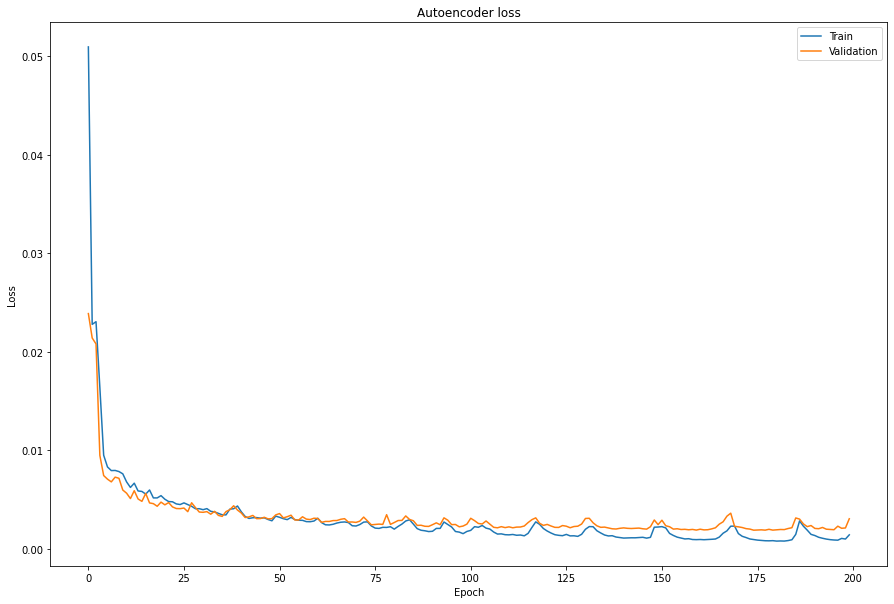

In [286]:
#plot train and validation loss of pretraining
plt.figure(figsize=(15,10))
plt.plot(autoencoder.history.history['loss'])
plt.plot(autoencoder.history.history['val_loss'])
plt.title('Autoencoder loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

#path = 'results/metrics_training/loss_autoencoder_pretrain.png'
#plt.savefig(path)

# Show prediction after pretraining CAE

In [287]:
#predict images and display

directories = ['data/train/', 
               'data/val/', 
               'data/test/']

scans=['CT','MRI','PET']

def PickListImagesPerType(directory,scan):
    names = [f for f in listdir(directory) if f[:2]==scan[:2]]
    return names

def PickOneImage(names,directory,n):
    image = io.imread(directory+names[n])
    image = cv2.resize(image, dsize=(128,128))
    return image

## Prediction on test dataset

Da riscrivere meglio scrivendo una funzione pred(path della directory di immagini (train, val, test)).
È tutto qui sotto è solo da mettere in un'unica funzione!

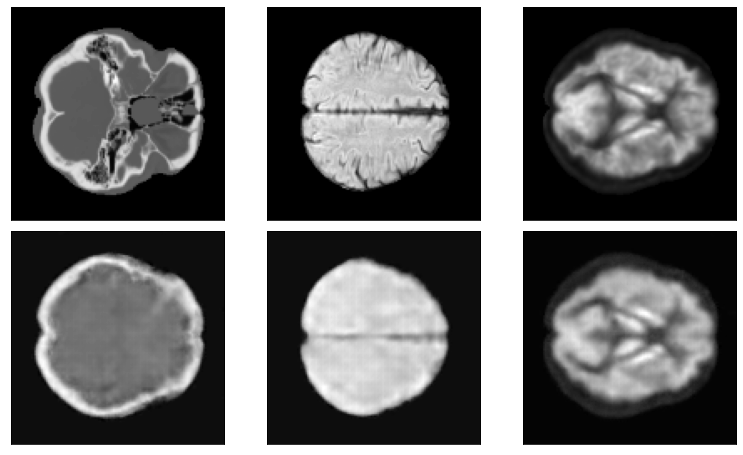

In [288]:
#image layer to display (change this to display different images and respective decoded ones)
n = 6

#ORIGINAL IMAGES
#pick one image per type of scan
imgsCT = PickOneImage(PickListImagesPerType(directories[2],scans[0]),directories[2],n)
imgsMRI = PickOneImage(PickListImagesPerType(directories[2],scans[1]),directories[2],n)
imgsPET = PickOneImage(PickListImagesPerType(directories[2],scans[2]),directories[2],n)

#DECODED IMAGES
#costruisco la lista di immagini da decodificare
listaCT=[]
for f in PickListImagesPerType(directories[2],scans[0]): 
    listaCT.append(join(directories[2], f))

listaMRI=[]
for f in PickListImagesPerType(directories[2],scans[1]): 
    listaMRI.append(join(directories[2], f))
    
listaPET=[]
for f in PickListImagesPerType(directories[2],scans[2]): 
    listaPET.append(join(directories[2], f))

#decode images per type of scan
decoded_imgsCT = autoencoder.predict(ReshapeCAE(WriteAndArrayImages(listaCT)))
decoded_imgsMRI = autoencoder.predict(ReshapeCAE(WriteAndArrayImages(listaMRI)))
decoded_imgsPET = autoencoder.predict(ReshapeCAE(WriteAndArrayImages(listaPET)))

#select one decoded image and make in plottable
decoded_imgCT = decoded_imgsCT[n].reshape(128,128)
decoded_imgMRI = decoded_imgsMRI[n].reshape(128,128)
decoded_imgPET = decoded_imgsPET[n].reshape(128,128)

fig = plt.figure(figsize=(13,10))

#plot images
ax = plt.subplot(2,3,1)
plt.imshow(imgsCT)
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(2,3,2)
plt.imshow(imgsMRI)
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(2,3,3)
plt.imshow(imgsPET)
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(2,3,4)
plt.imshow(decoded_imgCT)
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(2,3,5)
plt.imshow(decoded_imgMRI)
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(2,3,6)
plt.imshow(decoded_imgPET)
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.subplots_adjust(wspace=0.2, hspace=-0.3)

# DCEC Model

In [141]:
#autoencoder.load_weights(save_dir+'/cae_conv2Dtranspose_weights.h5')

### Clustering Layer

In [142]:
from keras.engine.topology import Layer

class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.

    # Example
    ```
        model.add(ClusteringLayer(n_clusters=3))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: degrees of freedom parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
         Measure the similarity between embedded point z_i and centroid µ_j.
                 q_ij = 1/(1+dist(x_i, µ_j)^2), then normalize it.
                 q_ij can be interpreted as the probability of assigning sample i to cluster j.
                 (i.e., a soft assignment)
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) # Make sure each sample's 10 values add up to 1.
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [143]:
from keras.engine.topology import InputSpec

clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input, outputs=[clustering_layer, autoencoder.output])

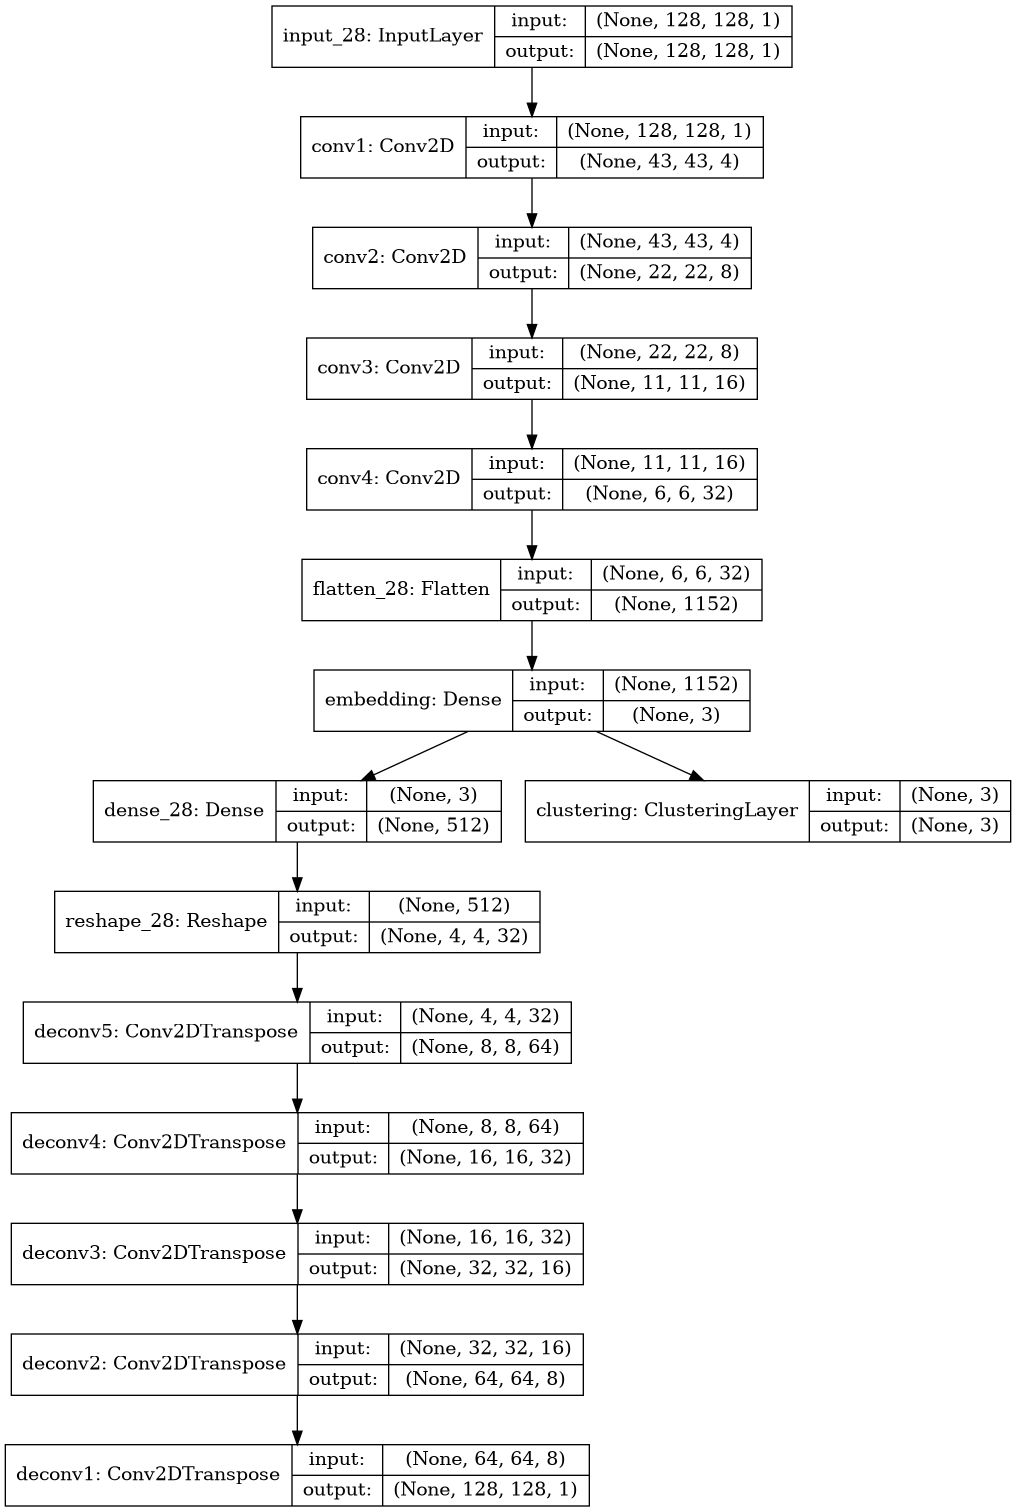

In [144]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

## Inizialize cluster centers using k-means

In [145]:
from sklearn.cluster import KMeans
import metrics as metrics

kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(x_train))
y_pred_last = np.copy(y_pred)
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

In [146]:
print('Metrics before training.')
print('acc=', metrics.acc(y_train, y_pred), 'nmi=', metrics.nmi(y_train, y_pred), 'ari=', metrics.ari(y_train, y_pred))

Metrics before training.
acc= 0.5354713313896987 nmi= 0.162786200303439 ari= 0.09644448460867955


/home/phil/anaconda3/envs/tesi/lib/python3.8/site-packages/sklearn/utils/linear_assignment_.py:18: FutureWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/home/phil/anaconda3/envs/tesi/lib/python3.8/site-packages/sklearn/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


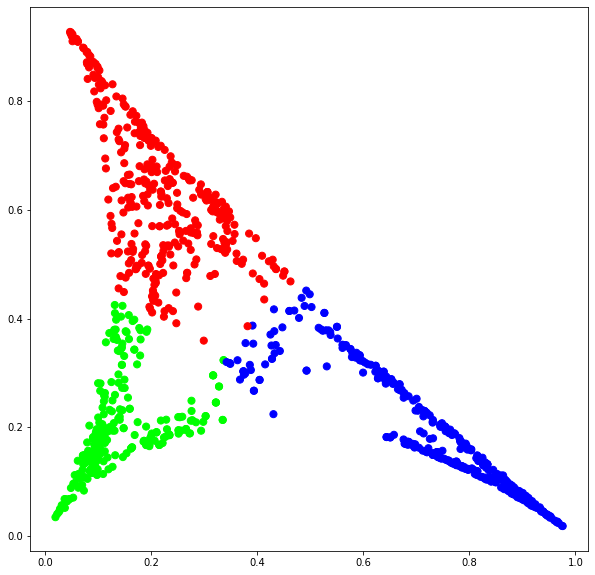

In [147]:
features = model.predict(x_train)[0]

plt.figure(figsize=(10,10))
plt.scatter(features[:,0], features[:,1], c=y_pred, s=50, cmap='brg')

#centers = kmeans.cluster_centers_
#plt.scatter(centers[:,0], centers[:,1], c='black', s=200, alpha=0.5)

# Training DCEC

In [148]:
# Student's distribution (see paper)
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

In [158]:
# hyperparams
batch_size= 64
maxiter = 20000
update_interval = 140
save_interval = 1000
tol = 0.001 # tolerance as threshold to early stopping

# init 
index = 0
train_loss = []

# plots
history_train_losses = [[],[],[]]
history_train_acc=[]
iterazioni=[]

## Compile

In [159]:
# compile model
gamma = 0.1
optimizer = 'adam'

model.compile(loss=['kld', 'mse'], loss_weights=[gamma, 1], optimizer=optimizer)

## Train

In [160]:
import metrics

for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q, _ = model.predict(x_train, verbose=0)
        p = target_distribution(q) # update the auxiliary target distribution p

        # evaluate the clustering performance
        y_train_pred = q.argmax(1)
        if y_train is not None:
            train_acc = np.round(metrics.acc(y_train, y_train_pred), 5)
            train_nmi = np.round(metrics.nmi(y_train, y_train_pred), 5)
            train_ari = np.round(metrics.ari(y_train, y_train_pred), 5)
            train_loss = np.round(train_loss, 5)
            print('Iter', ite, ': Acc tr', train_acc, ', nmi tr', train_nmi, ', ari tr', train_ari, '; loss tr=', train_loss)
       
        # check stop criterion
        delta_label = np.sum(y_train_pred != y_pred_last).astype(np.float32) / y_train_pred.shape[0]
        y_pred_last = np.copy(y_train_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    
    # train on batch
    if (index + 1) * batch_size > x_train.shape[0]:
        train_loss = model.train_on_batch(x=x_train[index * batch_size::],
                                     y=[p[index * batch_size::], x_train[index * batch_size::]])
        index = 0
    else:
        train_loss = model.train_on_batch(x=x_train[index * batch_size:(index + 1) * batch_size],
                                     y=[p[index * batch_size:(index + 1) * batch_size],
                                        x_train[index * batch_size:(index + 1) * batch_size]])
        index += 1
    
    history_train_losses[0].append(train_loss[0])
    history_train_losses[1].append(train_loss[1])
    history_train_losses[2].append(train_loss[2])
    history_train_acc.append(train_acc)

    iterazioni.append(ite)
    
    if ite % save_interval == 0:
        # save DCEC model checkpoints
        print('saving model to:', save_dir + '/dcec_model_' + str(ite) + '.h5')
        model.save_weights(save_dir + '/dcec_model_' + str(ite) + '.h5')
        
    ite += 1

# save the trained model
print('saving model to:', save_dir + '/dcec_model_final.h5')
model.save_weights(save_dir + '/dcec_model_final.h5')

/home/phil/anaconda3/envs/tesi/lib/python3.8/site-packages/sklearn/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


Iter 0 : Acc tr 0.5034 , nmi tr 0.14576 , ari tr 0.06373 ; loss tr= []
saving model to: ./results/dcec_model_0.h5


/home/phil/anaconda3/envs/tesi/lib/python3.8/site-packages/sklearn/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


Iter 100 : Acc tr 0.49174 , nmi tr 0.13743 , ari tr 0.06771 ; loss tr= [0.01388 0.03219 0.01066]


/home/phil/anaconda3/envs/tesi/lib/python3.8/site-packages/sklearn/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


Iter 200 : Acc tr 0.47133 , nmi tr 0.1272 , ari tr 0.05049 ; loss tr= [0.01272 0.03866 0.00885]


/home/phil/anaconda3/envs/tesi/lib/python3.8/site-packages/sklearn/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


Iter 300 : Acc tr 0.46744 , nmi tr 0.12517 , ari tr 0.04851 ; loss tr= [0.01343 0.069   0.00653]


/home/phil/anaconda3/envs/tesi/lib/python3.8/site-packages/sklearn/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


Iter 400 : Acc tr 0.4655 , nmi tr 0.12485 , ari tr 0.04862 ; loss tr= [0.02261 0.11472 0.01114]


/home/phil/anaconda3/envs/tesi/lib/python3.8/site-packages/sklearn/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


Iter 500 : Acc tr 0.46064 , nmi tr 0.12333 , ari tr 0.04587 ; loss tr= [0.01344 0.06591 0.00685]


KeyboardInterrupt: 

## Validation

## Plot DCEC metrics

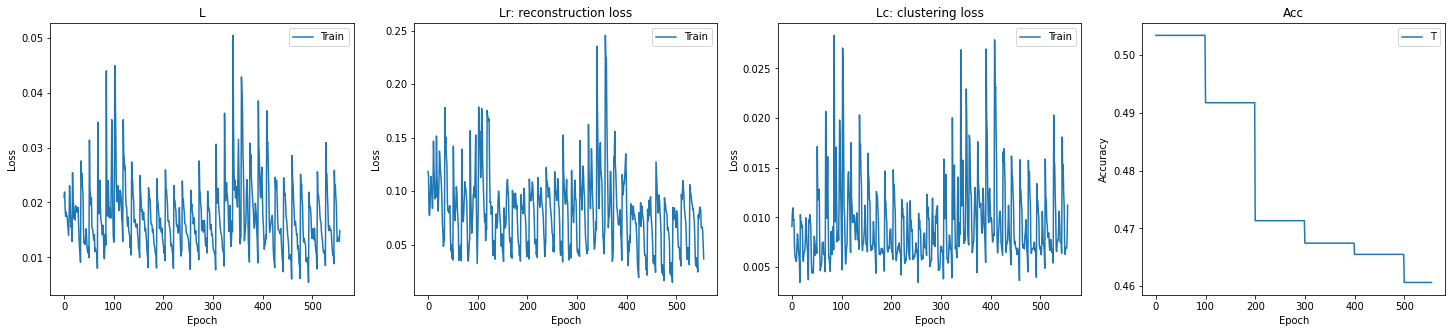

In [162]:
plt.figure(figsize=(25,5))
plt.subplot(1,4,1)
x1=iterazioni
y1=history_train_losses[0]
#y2=history_val_losses[0]
plt.plot(x1,y1)
#plt.plot(x1,y2)
plt.title('L')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.subplot(1,4,2)
x1=iterazioni
y1=history_train_losses[1]
#y2=history_val_losses[1]
plt.plot(x1,y1)
#plt.plot(x1,y2)
plt.title('Lr: reconstruction loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.subplot(1,4,3)
x1=iterazioni
y1=history_train_losses[2]
#y2=history_val_losses[2]
plt.plot(x1,y1)
#plt.plot(x1,y2)
plt.title('Lc: clustering loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.subplot(1,4,4)
x1=iterazioni
y1=history_train_acc
#y2=history_val_acc
plt.plot(x1,y1)
#plt.plot(x1,y2)
plt.title('Acc')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend('Train')

plt.show()

# Final evaluation on test dataset

In [ ]:
q, _ = model.predict(x_test, verbose=0)
p = target_distribution(q) 

test_loss = model.fit(x=x_test, y=[p, x_test])
print(' Acc', acc) 

## Show prediction after training DCEC

### Prediction on test dataset

In [ ]:
#image layer to display (change this to display different images and respective decoded ones)
n = 8 

#ORIGINAL IMAGES
#pick one image per type of scan
imgsCT = PickOneImage(PickListImagesPerType(directories[2],scans[0]),directories[2],n)
imgsMRI = PickOneImage(PickListImagesPerType(directories[2],scans[1]),directories[2],n)
imgsPET = PickOneImage(PickListImagesPerType(directories[2],scans[2]),directories[2],n)

#DECODED IMAGES
#costruisco la lista di immagini da decodificare
listaCT=[]
for f in PickListImagesPerType(directories[2],scans[0]): 
    listaCT.append(join(directories[2], f))

listaMRI=[]
for f in PickListImagesPerType(directories[2],scans[1]): 
    listaMRI.append(join(directories[2], f))
    
listaPET=[]
for f in PickListImagesPerType(directories[2],scans[2]): 
    listaPET.append(join(directories[2], f))

#decode images per type of scan
decoded_imgsCT = model.predict(ReshapeCAE(WriteAndArrayImages(listaCT)))[1]
decoded_imgsMRI = model.predict(ReshapeCAE(WriteAndArrayImages(listaMRI)))[1]
decoded_imgsPET = model.predict(ReshapeCAE(WriteAndArrayImages(listaPET)))[1]

#select one decoded image and make in plottable
decoded_imgCT = decoded_imgsCT[n].reshape(128,128)
decoded_imgMRI = decoded_imgsMRI[n].reshape(128,128)
decoded_imgPET = decoded_imgsPET[n].reshape(128,128)



#plot images
fig = plt.figure(figsize=(13,10))

ax = plt.subplot(2,3,1)
plt.imshow(imgsCT)
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(2,3,2)
plt.imshow(imgsMRI)
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(2,3,3)
plt.imshow(imgsPET)
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(2,3,4)
plt.imshow(decoded_imgCT)
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(2,3,5)
plt.imshow(decoded_imgMRI)
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(2,3,6)
plt.imshow(decoded_imgPET)
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# Plotting clusters

### Train

In [ ]:
features = feature_model.predict(x_train)
y_pred = km.fit_predict(features)
plt.figure(figsize=(12,10))
plt.scatter(features[:,0], features[:,1], c=y_pred, s=50, cmap='brg')
centers = km.cluster_centers_
plt.scatter(centers[:,0], centers[:,1], c='black', s=200, alpha=0.5)

### Test

In [ ]:
features = feature_model.predict(x_test)
y_pred = km.fit_predict(features)
plt.figure(figsize=(12,10))
plt.scatter(features[:,0], features[:,1], c=y_pred, s=50, cmap='brg')
centers = km.cluster_centers_
plt.scatter(centers[:,0], centers[:,1], c='black', s=200, alpha=0.5)

## Confusion matrix

In [ ]:
import seaborn as sns
import sklearn.metrics
import matplotlib.pyplot as plt
sns.set(font_scale=3)
confusion_matrix = sklearn.metrics.confusion_matrix([int(i) for i in y_test], y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Clustering label')
plt.show()

In [ ]:
from sklearn.utils.linear_assignment_ import linear_assignment

y_true = y.astype(np.int64)
D = max(y_pred.max(), y_true.max()) + 1
w = np.zeros((D, D), dtype=np.int64)
# Confusion matrix.
for i in range(y_pred.size):
    w[y_pred[i], y_true[i]] += 1
ind = linear_assignment(-w)

sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

In [ ]:
ind